In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib
import numpy as np
from tensorflow.keras.preprocessing import image
from skimage.io import imread
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten,Dropout, Conv2D
from tensorflow.keras import Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
def load_image_paths(container_path):
    image_dir = pathlib.Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    image_paths = []
    flat_data = []
    target = []
    count = 0
    train_img_path = []
    train_label = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            count += 1
            train_img_path.append(str(file))
            train_label.append(categories[i])

    X = np.array(train_img_path)
    y = np.array(train_label)
    catStringArr = np.array(categories)

    return X, y, catStringArr


In [4]:
X = []
y = []
X, y, labelStringArr = load_image_paths("/home/pascal_steiger/Downloads/data7/")
img_df = pd.DataFrame(zip(X, y), columns=["path", "label"])

print(labelStringArr)

img_df.sample(n=10)

['MKD' 'ISL' 'ITA' 'GBR' 'FIN' 'PRT' 'CHE']


,path,label
6086,/home/pascal_steiger/Downloads/data7/CHE/img_4...,CHE
5158,/home/pascal_steiger/Downloads/data7/PRT/img_P...,PRT
6019,/home/pascal_steiger/Downloads/data7/CHE/img_4...,CHE
3772,/home/pascal_steiger/Downloads/data7/GBR/img_5...,GBR
3954,/home/pascal_steiger/Downloads/data7/GBR/img_5...,GBR
3703,/home/pascal_steiger/Downloads/data7/GBR/img_5...,GBR
642,/home/pascal_steiger/Downloads/data7/MKD/img_M...,MKD
5140,/home/pascal_steiger/Downloads/data7/PRT/img_P...,PRT
4702,/home/pascal_steiger/Downloads/data7/FIN/img_F...,FIN
953,/home/pascal_steiger/Downloads/data7/MKD/img_M...,MKD


In [5]:
train_df, test_df = train_test_split(img_df, shuffle=True, test_size=0.2, random_state=42)


print(train_df.sample(n=5))
print(train_df.shape)
print(test_df.sample(n=5))
print(test_df.shape)


                                                   path label
4263  /home/pascal_steiger/Downloads/data7/FIN/img_F...   FIN
274   /home/pascal_steiger/Downloads/data7/MKD/img_M...   MKD
4000  /home/pascal_steiger/Downloads/data7/GBR/img_5...   GBR
1196  /home/pascal_steiger/Downloads/data7/ISL/img_I...   ISL
2661  /home/pascal_steiger/Downloads/data7/ITA/img_I...   ITA
(5611, 2)
                                                   path label
5889  /home/pascal_steiger/Downloads/data7/PRT/img_P...   PRT
5071  /home/pascal_steiger/Downloads/data7/PRT/img_P...   PRT
3979  /home/pascal_steiger/Downloads/data7/GBR/img_5...   GBR
5038  /home/pascal_steiger/Downloads/data7/PRT/img_P...   PRT
434   /home/pascal_steiger/Downloads/data7/MKD/img_M...   MKD
(1403, 2)


In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator()

In [7]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="path",
        y_col="label",
        target_size=(380, 380),
        batch_size=32,
        class_mode="sparse",
        seed=42
)


validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="path",
        y_col="label",
        target_size=(380, 380),
        batch_size=32,
        class_mode="sparse",
        shuffle=False
)

Found 5611 validated image filenames belonging to 7 classes.
Found 1403 validated image filenames belonging to 7 classes.


In [8]:
with tf.device("/device:GPU:1"):
    from tensorflow.keras.applications import EfficientNetB4
    tl_efnet = EfficientNetB4(include_top=True,weights="imagenet")
    tl_efnet = tf.keras.Model(tl_efnet.input, tl_efnet.layers[-2].output)
    
    for layer in tl_efnet.layers:
        layer.trainable = False

    for layer in tl_efnet.layers[-5:]:
        layer.trainable = True 
    

In [9]:
tl_efnet.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 380, 380, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 380, 380, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [10]:
with tf.device("/device:GPU:1"):

    I = Input(shape=(380, 380, 3))



    x = tl_efnet(I)



    dense = Dense(1024, activation='relu', name='denserelu')(x)
    
    dropout = Dropout(0.1)(dense)

    dense2 = Dense(512, activation='relu', name='denserelu2')(dropout)
    
    dropout2 = Dropout(0.1)(dense2)

    dense3 = Dense(7, activation='softmax', name='my_dense')(dropout2)

    #prediction = Dense(26, activation='softmax', name='prediction')



    #out2 = prediction(x)


    new_model2 = tf.keras.Model(I, dense3)

    new_model2.summary()





Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 380, 380, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 1792)              17673823  
_________________________________________________________________
denserelu (Dense)            (None, 1024)              1836032   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
denserelu2 (Dense)           (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
my_dense (Dense)             (None, 7)                 3591

In [11]:
def unwrap_model(model):
    mdl = model.get_layer('model')
    inp = mdl.input
    out = model.get_layer('denserelu')(mdl.output)
    out = model.get_layer('dropout')(out)
    out = model.get_layer('denserelu2')(out)
    out = model.get_layer('dropout_1')(out)
    out = model.get_layer('my_dense')(out)
    return tf.keras.Model(inp, out)   
    
new_model2 = unwrap_model(new_model2)

    
new_model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 380, 380, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 380, 380, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [12]:
# define callbacks for early stopping

early_stopping = EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [13]:
with tf.device("/device:GPU:1"):
    new_model2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

with tf.device("/device:GPU:1"):
    history = new_model2.fit(
          train_generator,
          epochs=200,
          verbose = 1,
          callbacks=callbacks,
          validation_data=validation_generator)
    new_model2.save('CNN-TL_efficientNet-data7.h5')

Epoch 1/200
176/176 [==============================] - 228s 1s/step - loss: 1.1888 - sparse_categorical_accuracy: 0.5557 - val_loss: 0.9601 - val_sparse_categorical_accuracy: 0.6593
Epoch 2/200
176/176 [==============================] - 210s 1s/step - loss: 0.9298 - sparse_categorical_accuracy: 0.6610 - val_loss: 0.8519 - val_sparse_categorical_accuracy: 0.6686
Epoch 3/200
176/176 [==============================] - 211s 1s/step - loss: 0.7989 - sparse_categorical_accuracy: 0.7024 - val_loss: 0.8649 - val_sparse_categorical_accuracy: 0.6942
Epoch 4/200
176/176 [==============================] - 209s 1s/step - loss: 0.7456 - sparse_categorical_accuracy: 0.7291 - val_loss: 0.7255 - val_sparse_categorical_accuracy: 0.7327
Epoch 5/200
176/176 [==============================] - 208s 1s/step - loss: 0.6790 - sparse_categorical_accuracy: 0.7546 - val_loss: 0.7193 - val_sparse_categorical_accuracy: 0.7398
Epoch 6/200
176/176 [==============================] - 209s 1s/step - loss: 0.6167 - spars

176/176 [==============================] - 210s 1s/step - loss: 0.0988 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.8086 - val_sparse_categorical_accuracy: 0.8154
Epoch 46/200
176/176 [==============================] - 208s 1s/step - loss: 0.1096 - sparse_categorical_accuracy: 0.9622 - val_loss: 0.8086 - val_sparse_categorical_accuracy: 0.8190
Epoch 47/200
176/176 [==============================] - 218s 1s/step - loss: 0.1008 - sparse_categorical_accuracy: 0.9649 - val_loss: 0.8243 - val_sparse_categorical_accuracy: 0.8147
Epoch 48/200
176/176 [==============================] - 207s 1s/step - loss: 0.0911 - sparse_categorical_accuracy: 0.9690 - val_loss: 0.8100 - val_sparse_categorical_accuracy: 0.8125
Epoch 49/200
176/176 [==============================] - 208s 1s/step - loss: 0.0958 - sparse_categorical_accuracy: 0.9663 - val_loss: 0.8289 - val_sparse_categorical_accuracy: 0.8204
Epoch 50/200
176/176 [==============================] - 207s 1s/step - loss: 0.0832 - sparse_categ

/home/pascal_steiger/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


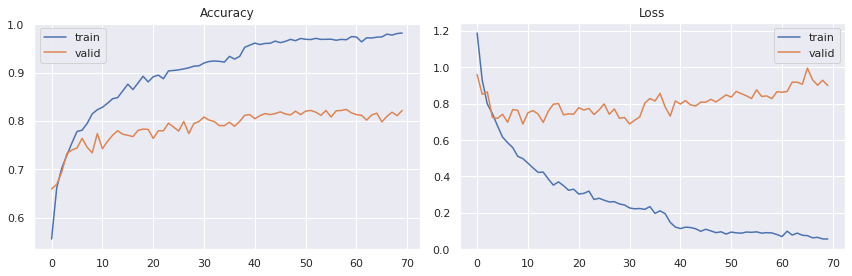

In [14]:
# plot training and validation metrics

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['sparse_categorical_accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_sparse_categorical_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('CNN(380,380)-tl_efficientnet-data7.png')

plt.show()

In [15]:
with tf.device("/device:GPU:1"):
    model2 = tf.keras.models.load_model('CNN-TL_efficientNet-data7.h5')

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
num_of_test_samples=1403
batch_size=32
with tf.device("/device:GPU:1"):
    Y_pred = model2.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = sorted(labelStringArr)
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/home/pascal_steiger/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[163   6  12   0   3   6   2]
 [  2 185   2   4   5   0   0]
 [ 12   5 144   4  20   4   6]
 [  2   1   3 201   4   2   2]
 [  5   6   9   1 128  16  24]
 [  3   1   2   2  13 171  11]
 [  9   3   6   1  19   9 164]]
Classification Report
              precision    recall  f1-score   support

         CHE       0.83      0.85      0.84       192
         FIN       0.89      0.93      0.91       198
         GBR       0.81      0.74      0.77       195
         ISL       0.94      0.93      0.94       215
         ITA       0.67      0.68      0.67       189
         MKD       0.82      0.84      0.83       203
         PRT       0.78      0.78      0.78       211

    accuracy                           0.82      1403
   macro avg       0.82      0.82      0.82      1403
weighted avg       0.82      0.82      0.82      1403

